In [23]:
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy
import time
import math

In [24]:
FROM_DATASET = True
N_SAMPLES = 10000
PARTITION = int(N_SAMPLES*0.1)
ITERS = 30
EPSILON = 1e-5

#diabetes, smoking, Surgical-deepnet.csv
DATABASE = 'Surgical-deepnet'

In [25]:

if not FROM_DATASET:
    # Set random seed for reproducibility
    np.random.seed(420)

    # Create dataset with 10,000 points and 2 clusters
    #X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
    y = np.where(y == 0, -1, y)

    # Print the shapes of X and y
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Create scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Add axis labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

    # Show the plot
    plt.show()

else:

    if DATABASE == "diabetes":
        data = np.genfromtxt('diabetes.csv', delimiter=',', skip_header=1)
        X = data[:, :-1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)
    
    if DATABASE == "smoking":
        data = np.genfromtxt('smoking.csv', delimiter=',', skip_header=1)
        X = data[:, : -1]
        y = data[:, -1]

        columns_to_remove = [0, 1, 23, 25]
        X = np.delete(X, columns_to_remove, axis=1) 
        X = X[:10000]
        y = np.where(y == 0, -1, y)
        y = y[:10000]

    if DATABASE == "Surgical-deepnet":
        data = np.genfromtxt('Surgical-deepnet.csv', delimiter=',', skip_header=1)
        X = data[:, : -1]
        y = data[:, -1]
        y = np.where(y == 0, -1, y)


In [26]:
print("Dataset Lenght")
print("Tot: " + str(len(X)) + ", lab: " + str(PARTITION) + ", unlab: " + str(len(X)-PARTITION))

X.shape

Dataset Lenght
Tot: 14635, lab: 1000, unlab: 13635


(14635, 24)

In [27]:

# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

# Label initialization
labeled_y = np.array(y[:PARTITION])
target_y = np.array(y[PARTITION:])
initial_y = np.random.choice([-1,1], size = (len(unlabeled_X,)))

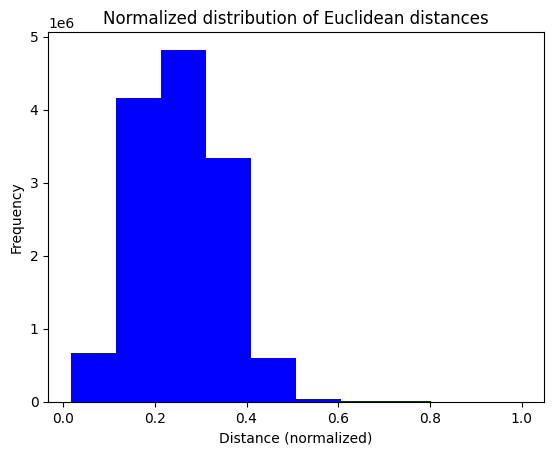

In [28]:

# Calculate distances
labeled_distances = cdist(labeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

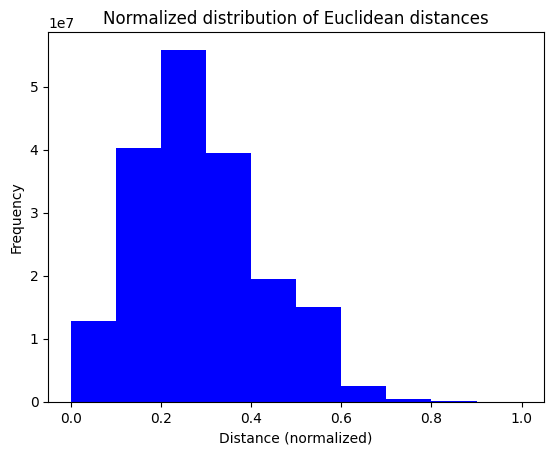

In [29]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()


In [30]:
if not FROM_DATASET:
    plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
    plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=labeled_y)
    plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-10 ||a-b||^2_2}
$$

In [31]:
def weight(dist):
    return math.e**(-10*dist**2)

In [32]:
%%time
print("Computing weights")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Computing weights
Done
CPU times: total: 25.3 s
Wall time: 1min 49s


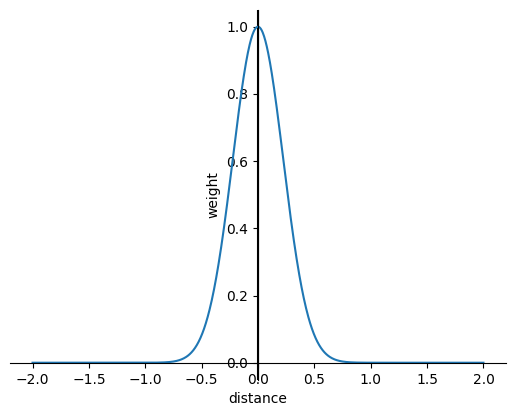

In [33]:
X = np.linspace(-2, 2, 1000)
plt.figure(dpi=100)
ax = plt.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X], label="asd")

The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [34]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * labeled_unlabeled_weights.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * unlabeled_unlabeled_weights.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [35]:
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            target_y
        )
    ) / len(target_y)

def accuracy(current):
    return accuracy_round(current) #loss(labeled_y, current)

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj} \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$


### Hessian and constants

In [36]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(target_y)):
        mat[i][i] = 2 * np.sum(labeled_unlabeled_weights[:,i]) + np.sum(unlabeled_unlabeled_weights[:,i]) - unlabeled_unlabeled_weights[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

print("Calculating the Hessian matrix")
hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)
print("Calculating sigma (strongly convex)")
sigma = estimate_degree_strongly_convex(hessian)
strongly_convex = sigma > 0
print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
print("Estimating Lipschitz constant for the whole function")
L = estimate_lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")


Calculating the Hessian matrix

Calculating sigma (strongly convex)
Sigma: 265.0606650698709,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 10290.361693610752
CPU times: total: 27min 44s
Wall time: 8min 17s


Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [37]:
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))
grad_first_coeff_vec = (2 * sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    labeled_y.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [38]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [39]:
y_unlabeled_gd = np.copy(initial_y)

In [40]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(labeled_y, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(labeled_y, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(labeled_y, y_unlabeled_gd)}
""")

00% - iter 0 / 30 - final accuracy 52.04% - loss 12517434.40
10% - iter 3 / 30 - final accuracy 72.86% - loss 3109252.47
20% - iter 6 / 30 - final accuracy 72.87% - loss 1653465.78
30% - iter 9 / 30 - final accuracy 72.89% - loss 889590.88
40% - iter 12 / 30 - final accuracy 72.90% - loss 479433.87
50% - iter 15 / 30 - final accuracy 72.93% - loss 258740.94
60% - iter 18 / 30 - final accuracy 72.93% - loss 139860.28
70% - iter 21 / 30 - final accuracy 72.93% - loss 75752.69
80% - iter 24 / 30 - final accuracy 72.93% - loss 41139.42
90% - iter 27 / 30 - final accuracy 72.93% - loss 22423.20

Final accuracy: 72.93%
Norm gradient: 5273.3246385047505
Loss: 15002.595570412203

CPU times: total: 2min 57s
Wall time: 9min 37s


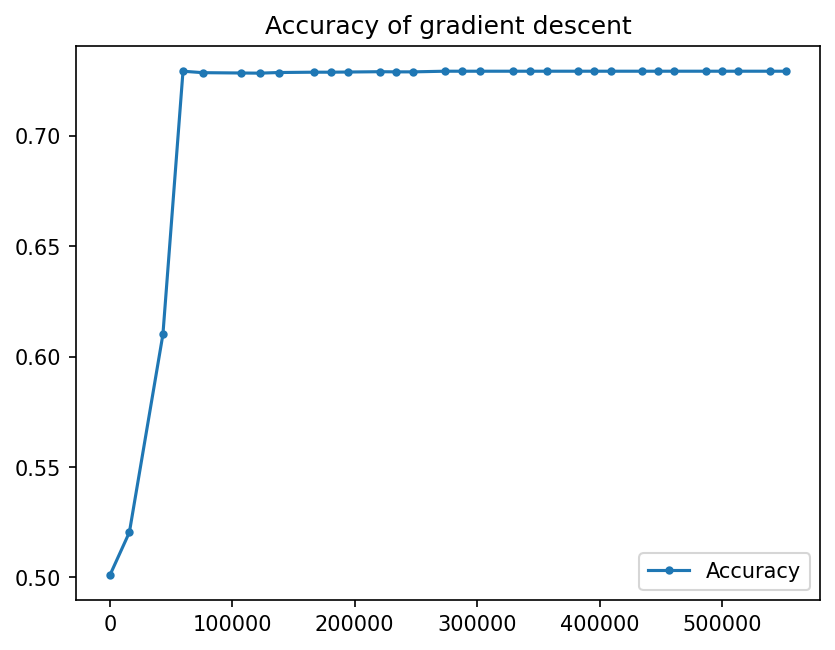

In [41]:
plt.figure(dpi=150)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [42]:
y_unlabeled_gd_improved = np.copy(initial_y)

In [43]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(labeled_y, y_unlabeled_gd_improved)]
init_time = time.time() * 1000
for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if strongly_convex else 1)/(L + (sigma if strongly_convex else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(labeled_y, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(labeled_y, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 30 - final accuracy 53.27% - loss 34529857.00
10% - iter 3 / 30 - final accuracy 73.24% - loss 6214931.17
20% - iter 6 / 30 - final accuracy 72.93% - loss 1740802.91
30% - iter 9 / 30 - final accuracy 72.93% - loss 588972.37
40% - iter 12 / 30 - final accuracy 72.93% - loss 228078.10
50% - iter 15 / 30 - final accuracy 72.93% - loss 98792.31
60% - iter 18 / 30 - final accuracy 72.94% - loss 46919.52
70% - iter 21 / 30 - final accuracy 72.94% - loss 24020.53
80% - iter 24 / 30 - final accuracy 72.94% - loss 13036.12
90% - iter 27 / 30 - final accuracy 72.94% - loss 7405.87

Final accuracy: 72.94%
Norm gradient: 7493.000303875147
Loss: 5183.672904463316

CPU times: total: 2min 5s
Wall time: 10min 34s


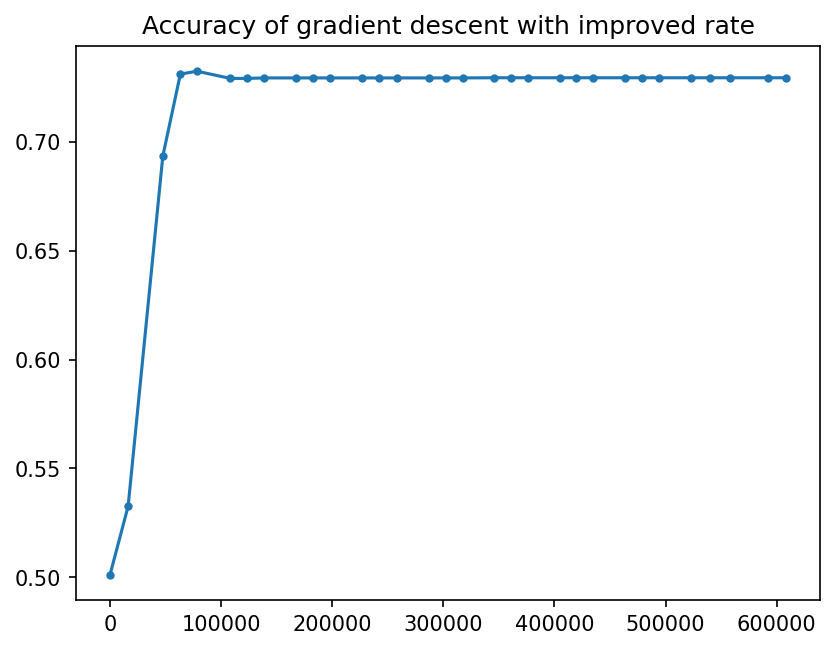

In [44]:
plt.figure(dpi=150)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

### Accelerated Gradient

In [47]:
y_unlabeled_gd_accelerated_previous = y_unlabeled_gd_accelerated = np.copy(initial_y)

In [48]:
%%time
ticks_gd_accelerated = [0]
accuracies_gd_accelerated = [accuracy(y_unlabeled_gd_accelerated)]
init_time = time.time() * 1000
losses_gd_accelerated = [loss(labeled_y, y_unlabeled_gd_accelerated)]
Alpha = 1
for i in range(ITERS):
    if i % (ITERS * 0.1) == 0 :
        print(f"{int(i/ITERS*100):02}% - iter {i} / {ITERS}", end="")
    start = time.process_time()
    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    new_position = y_unlabeled_gd_accelerated + Beta * (y_unlabeled_gd_accelerated - y_unlabeled_gd_accelerated_previous)
    grad = gradient(new_position)
    if EPSILON >= np.linalg.norm(grad):
        break

    old_y_unlabeled_gd_accelerated = np.copy(y_unlabeled_gd_accelerated)
    y_unlabeled_gd_accelerated = new_position - 1/L * grad
    y_unlabeled_gd_accelerated_previous = old_y_unlabeled_gd_accelerated

    accuracies_gd_accelerated.append(accuracy(y_unlabeled_gd_accelerated))
    losses_gd_accelerated.append(loss(labeled_y, y_unlabeled_gd_accelerated))
    ticks_gd_accelerated.append(time.time() * 1000 - init_time)

    if i % (ITERS * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_gd_accelerated[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_gd_accelerated):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_accelerated[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_accelerated))}
Loss: {loss(labeled_y, y_unlabeled_gd_accelerated)}
""")

00% - iter 0 / 30 - final accuracy 52.04% - loss 12517434.40
10% - iter 3 / 30 - final accuracy 72.84% - loss 2101274.90
20% - iter 6 / 30 - final accuracy 72.92% - loss 317433.39
30% - iter 9 / 30 - final accuracy 72.93% - loss 2301.73
40% - iter 12 / 30 - final accuracy 72.94% - loss 35507.04
50% - iter 15 / 30 - final accuracy 72.94% - loss 21835.42
60% - iter 18 / 30 - final accuracy 72.94% - loss 1466.84
70% - iter 21 / 30 - final accuracy 72.94% - loss 1966.19
80% - iter 24 / 30 - final accuracy 72.94% - loss 2830.62
90% - iter 27 / 30 - final accuracy 72.94% - loss 575.25

Final accuracy: 72.94%
Norm gradient: 241.75332106655537
Loss: 75.04051893891997

CPU times: total: 1min 56s
Wall time: 10min 23s


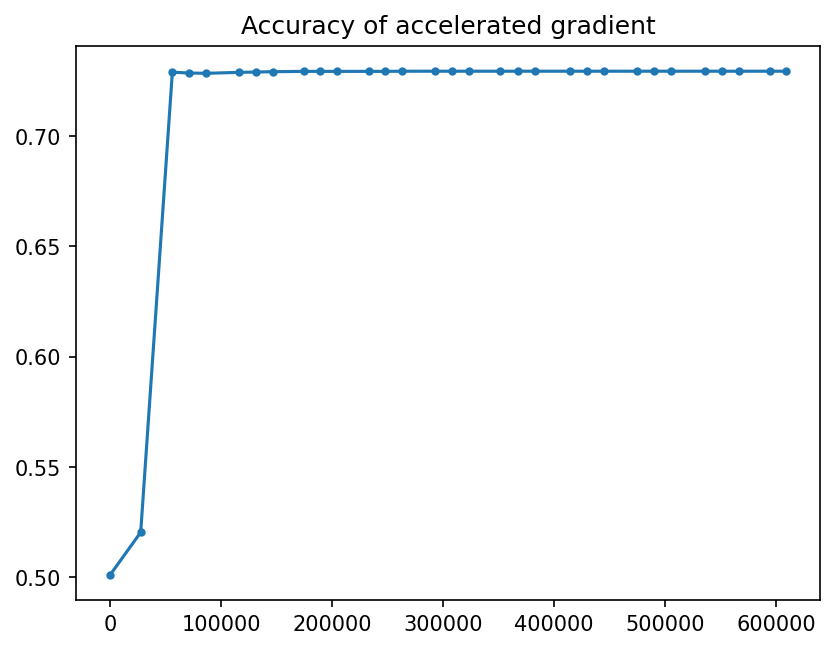

In [49]:
plt.figure(dpi=150)
plt.title("Accuracy of accelerated gradient")
plt.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [50]:
def derivative(unlabeled, j):
    return grad_first_coeff_vec[j] * unlabeled[j] - \
           grad_second_coeff_vec[j] - \
           np.matmul(w_unlabeled_unlabeled[:,j], unlabeled.T)

def derivative_iterative(labeled, unlabeled, j):
    tot = 0
    for i in range(len(labeled)):
        tot += 2*w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])
    for i in range(len(unlabeled)):
        tot += w_unlabeled_unlabeled[i][j] * (unlabeled[j] - unlabeled[i])
    return tot

def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [51]:
y_unlabeled_bcgd_random = np.copy(initial_y).astype("float64")

In [52]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(labeled_y, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(target_y) == 0:

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(labeled_y, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_random)}
""")

NameError: name 'Li' is not defined

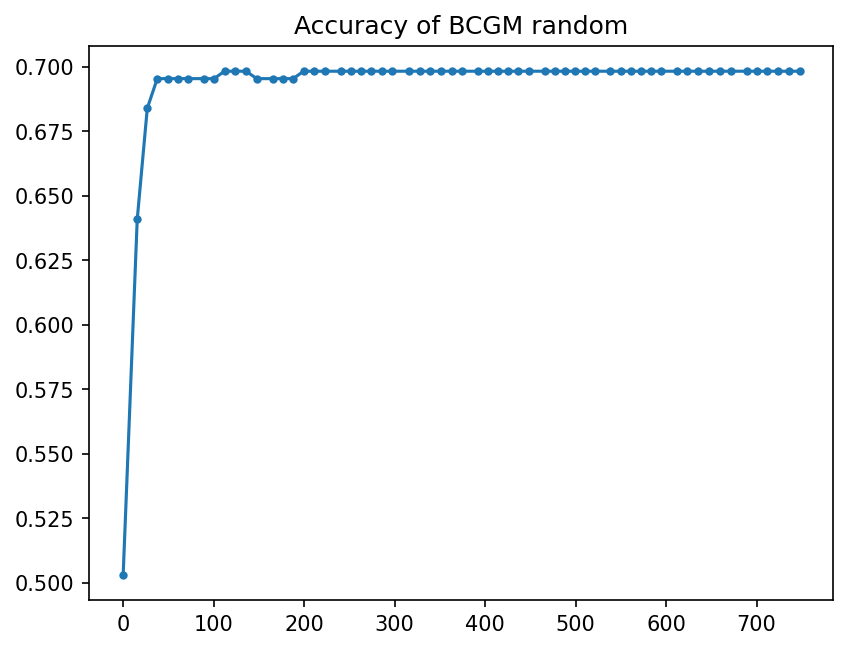

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Gauss-Southwell

In [ ]:
y_unlabeled_bcgd_gs = np.copy(initial_y).astype("float64")

In [ ]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(labeled_y, y_unlabeled_bcgd_gs)]

max_iterations = ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * 0.1) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(target_y) == 0:

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(labeled_y, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * 0.1) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(labeled_y, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(labeled_y, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 20880 - final accuracy 50.29% - loss 305055.92
10% - iter 2088 / 20880 - final accuracy 69.83% - loss 105546.57
20% - iter 4176 / 20880 - final accuracy 69.83% - loss 105546.57

Final accuracy: 69.83%
Norm gradient: 9.973435243220572e-06
Loss: 105546.56628717002

CPU times: user 182 ms, sys: 1.67 ms, total: 184 ms
Wall time: 183 ms


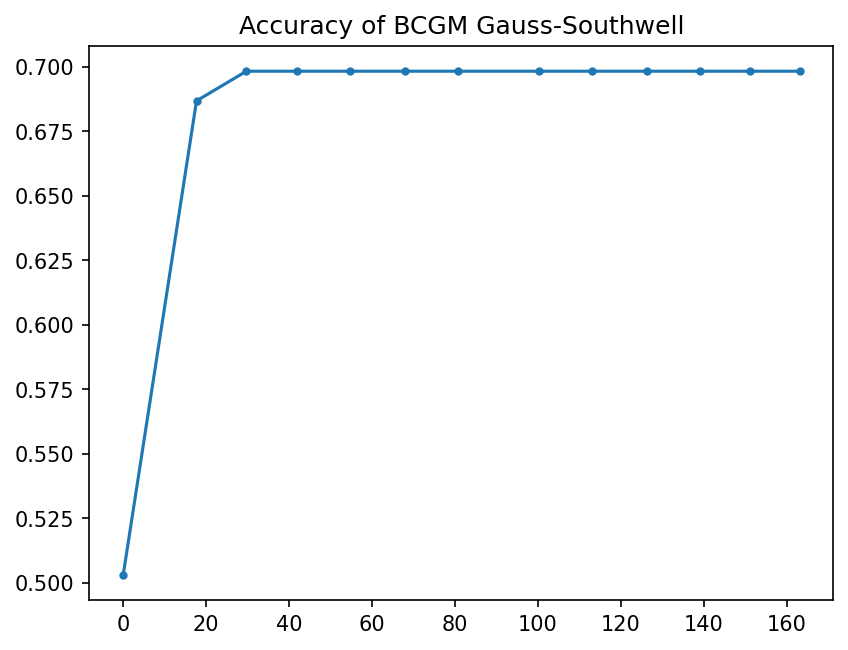

In [ ]:
plt.figure(dpi=150)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

### Loss

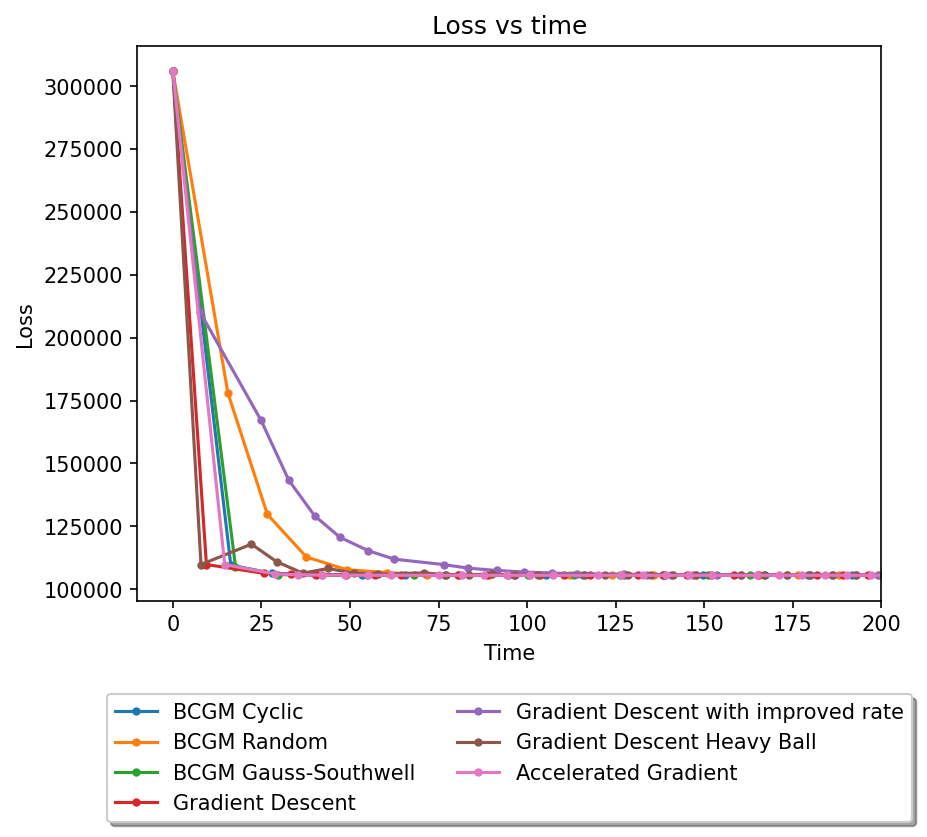

In [ ]:
plt.figure(dpi=150)
plt.plot(ticks_bcgd_random , losses_bcgm_random, marker='.')
plt.plot(ticks_bcgd_gs , losses_bcgm_gs, marker='.')
plt.plot(ticks_gd , losses_gd, marker='.')
plt.plot(ticks_gd_improved , losses_gd_improved, marker='.')
plt.plot(ticks_gd_accelerated , losses_gd_accelerated, marker='.')

plt.title("Loss vs time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.xlim(-10,200)
plt.legend(
    [
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)